### Imports

In [1]:
import numpy as np
import pandas as pd 
from collections import Counter
import os
import glob
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import scipy.stats as stats
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import math
import seaborn as sns
from combat.pycombat import pycombat
from matplotlib.backends.backend_pdf import PdfPages

### Read every cohort study file

In [2]:
datasets = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../cohort_studies_full_data/' + "/*."+'csv'))]
cohorts = [file.split(".")[0] for file in sorted(os.listdir('../cohort_studies_full_data/'))]

In [3]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies = dict()
# dfsss = dict()

for cohort, dataset in zip(cohorts, datasets):
    cohort_n = cohort.split("_MERGE")[0]
    cohort_studies[cohort_n] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit
#     dfsss[cohort_n] = dataset

In [4]:
datasets_sub = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../preprocessed_datasets/' + "/*."+'csv'))]
cohorts_sub = [file.split(".")[0] for file in sorted(os.listdir('../preprocessed_datasets/'))]

In [5]:
# make a dictionary that contains all cohorts as a dataframe
cohort_studies_sub = dict()

for cohort, dataset in zip(cohorts_sub, datasets_sub):
    cohort_studies_sub[cohort] = dataset.loc[dataset['Months']==0].copy() # reduce to BL visit

In [6]:
# add the preprocessed columns from sub table of each dataset to the main table of dataset
for i in cohort_studies:
#     cols = cohort_studies_sub[i].columns.difference(cohort_studies[i].columns)
    cols = ['Age', 'Sex', 'Education', 'APOE4', 'CDR', 'Race']
    
    for col in cols:
        
        if col in cohort_studies_sub[i].columns:
            cohort_studies[i][col] = cohort_studies_sub[i][col]

### Read harmonized mapping tables

In [7]:
modality = [pd.read_csv(file, sep=',') for file in sorted(glob.glob('../feature_tables' + "/*."+'csv'))]
name = [file.split(".")[0] for file in sorted(os.listdir('../feature_tables'))]

In [8]:
# make a dictionary that contains all modalities as a dataframe
mappings = dict()

for moda, na in zip(modality, name):
    mappings[na.split(' - ')[1]] = moda

In [9]:
harmonized_features = pd.concat(mappings, ignore_index=True) # combine all tables

In [10]:
# exclude categorical and taboo features
harmonized_features = harmonized_features.loc[(harmonized_features['Rank']!=1) & (harmonized_features['Rank']!=2)]

### Read the feature availability files for all cohorts

In [11]:
ava_mapp = [pd.read_csv(file, sep='\t') for file in sorted(glob.glob('../feature_availability_in_cohorts' + "/*."+'tsv'))]
tablesss = [file.split(".")[0] for file in sorted(os.listdir('../feature_availability_in_cohorts'))]

In [12]:
# make a dictionary that contains all modalities as a dataframe
available_features = dict()

for modal, df in zip(tablesss, ava_mapp):
    available_features[modal] = df

In [13]:
existing_features = pd.concat(available_features, ignore_index=True) # combine all tables

In [14]:
existing_features.replace({0: np.nan}, inplace=True) # 0 indicates that the feature was not measured 

### Read cutoffs obtained using all methods

In [15]:
table_method = [pd.read_csv(file, index_col=0, low_memory=False) for file in sorted(glob.glob('../results/cutoffs/' + "/*."+'csv'))]
method_name = [file.split(".")[0] for file in sorted(os.listdir('../results/cutoffs/'))]

In [16]:
# make a dictionary that contains each cutoff table as a dataframe
cutoffs_ = dict()

for tm, mn in zip(table_method, method_name):
    cutoffs_[mn] = tm

In [17]:
[cutoffs_['km_cutoffs'].rename(columns={col: col.split('_')[0]}, inplace=True) for col in cutoffs_['km_cutoffs'].columns]

[None, None, None]

### Selecetion of cohort studies for A/T/N assignment

### Select the patient that have CSF biomarker, disregard the diagnostic status

In [18]:
atn = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=mappings['csf'].Feature.loc[0:2].to_list()+(["Total"]))
# atn = pd.DataFrame(index=cohort_studies, columns=['A', 'T', 'N'])

In [19]:
for cohort in atn.index:
    for feat in mappings['csf'][cohort].loc[0:2].dropna().to_list():
        if feat in cohort_studies[cohort].columns:
            atn.loc[cohort, mappings['csf'].loc[mappings['csf'][cohort]==feat, 'Feature']] = len(cohort_studies[cohort][feat].dropna())
            atn.loc[cohort, 'Total'] = len(cohort_studies[cohort][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

In [20]:
# atn

In [21]:
diag = pd.DataFrame(index=available_features['csf'].iloc[:3].replace({0: np.nan}).dropna(axis=1).columns[1:].to_list(), columns=cohort_studies['ADNI']['Diagnosis'].dropna().unique())

In [22]:
for cohort in diag.index:
    for dia in diag.columns:
        diag.loc[cohort, dia] = len(cohort_studies[cohort].loc[cohort_studies[cohort]['Diagnosis']==dia][mappings['csf'][cohort].loc[0:2].dropna().to_list()].dropna())

### Remove the empty columns from all cohorts that we are intrested in
### Remove the participant without all 3 CSF biomarkers

In [23]:
selected_cohorts = dict()

for coh in diag.index:
    selected_cohorts[coh] = cohort_studies[coh].dropna(axis=1, how='all')

In [24]:
total_feats = dict()

# existing_features.set_index('Feature', inplace=True)

for feat in existing_features.Feature:
    total_feats[feat] = existing_features.loc[existing_features.Feature==feat][selected_cohorts].dropna(axis=1).columns

In [25]:
for cohort in atn.index:
    feat = mappings['csf'][cohort].loc[0:2].dropna().to_list()
    cohort_studies[cohort] = cohort_studies[cohort].dropna(subset=feat)

As Some features have suffix due to merging tables for certain cohorts, first investigate if all the harmonized features are in cohorts. Rename the ones that have suffix so it can be compatible to work with our harmonized names.

In [26]:
cohort_studies['ADNI'] = cohort_studies['ADNI'].rename(columns={'PTEDUCAT_x': 'PTEDUCAT', 'TRABSCOR_bl': 'TRABSCOR', 'LDELTOTAL_BL': 'LDELTOTAL'})

### CSF biomarkers, two classes, normal vs abnormal

In [27]:
# modality_ = ['clinical_i', 'clinical_ii','hippocampus', 'csf']
# modality_ = ['basal_ganglia', 'brain_poles_volume', 'cerebellum', 'clinical_i', 
#             'clinical_ii', 'csf', 'diencephalus', 'general_brain', 
#             'mri_others', 'pet', 'plasma', 'ventricles', 'hippocampus']
modality_ = ['basal_ganglia', 'brain_poles_volume', 'cerebellum', 'csf', 'diencephalus', 'general_brain', 
            'mri_others', 'pet', 'plasma', 'ventricles', 'hippocampus']

selected_feat = dict()

for i in modality_:
    selected_feat[i] = mappings[i]

In [28]:
# make a dataframe containing all the mapped features
features_all = pd.concat(selected_feat, ignore_index=True)

In [29]:
features_all = features_all[atn.index.union(['Feature', 'Rank'])] # subset the cohorts of interest

In [30]:
# remove the features that are not available in all studies
features_all = features_all.loc[features_all['Feature'].isin(existing_features[atn.index.union(['Feature'])].dropna(how='all')['Feature'].to_list())]

### Convert MRI measurements to mm3, same as ADNI and other cohorts

In [31]:
mri_nacc = ['basal_ganglia', 'brain_poles_volume', 'cerebellum', 'diencephalus', 'general_brain', 
            'mri_others', 'pet', 'plasma', 'ventricles', 'hippocampus']

for i in mri_nacc:
    
    for variable in mappings[i][['Feature', 'NACC']].dropna()['Feature'].to_list():
        
        if "Volume" in variable:
            nacc_var = mappings[i].loc[mappings[i]['Feature']==variable, 'NACC']
            cohort_studies['NACC'][nacc_var] = cohort_studies['NACC'][nacc_var] * 1000

In [32]:
nacc_mri_to_convert = list()

for i in mri_nacc:
    
    for feat_ in mappings[i]['NACC'].dropna().to_list():
        nacc_mri_to_convert.append(feat_)

* Rank 1 --> Categorical features
* Rank 2 --> Taboo features: some categorical and some numerical
* Rank nan --> Numerical features 

replace nan with 0

In [33]:
features_all['Rank'].replace({np.nan: 0}, inplace=True)

In [34]:
features_all.replace({"No total score.": np.nan}, inplace=True)

In [35]:
# fix PharmaCog column names
for i in cohort_studies['PharmaCog'].columns:
    if "\xa0" in i:
        new = str(i).replace(u'\xa0', u'')
        cohort_studies['PharmaCog'].rename(columns={i: new}, inplace=True)

## Prepare datasets

In [36]:
# def umap_atn_participants(dfss, cohorts, thresholds, features):
#     """cohorts: list of cohort names 
#        dfss: dictionary of cohorts where each key is the name of a cohort
#        thresholds: cutoff values obtained using a methodology
       
#        Select the features and participants and categorize the participant into ATN profiles using thresholds
#        obtained from each methodology.
       
#        return a df which contain the combination of paticipant from the selected cohorts while harmonizing
#        the features names.
#     """
    
#     # make a list of additional features to be investigated 
# #     additional_feat = ['Age', 'Sex', 'Education', 'APOE4', 'CDR', 'Race']
#     additional_feat = ['APOE4']

#     # make an empty dictionary to add the datasets to
#     df_= pd.DataFrame(columns=set(features.loc[features['Rank']==0]
#                                   [cohorts + ['Feature']].dropna()['Feature']).difference(['Feature'] + list(thresholds.columns)).union(additional_feat))
   
#     for i in cohorts:
# #         print(i)

#         dfs = dict()
#         dfs[i] = dfss[i].copy() # make a copy of the dataset of interest
#         # select the subset of datasets with features to be investigated
#         dfs[i] = dfs[i][features.loc[features['Rank']==0][cohorts + ['Feature']].dropna()[i].to_list() + additional_feat].dropna(axis=1, how='all')
#         # rename all the columns so we can concat the datasets later
#         [dfs[i].rename(columns={col: coln}, inplace=True) for col, coln in 
#          zip(features.loc[features['Rank']==0][cohorts + ['Feature']].dropna()[i].to_list(), 
#              features.loc[features['Rank']==0][cohorts + ['Feature']].dropna()['Feature'].to_list())]
#         dfs[i]['Cohort'] = i # add a cohort name column
#         # change the datatype to str as these are categorical features. astype doesn't work as it will include nan values
#         dfs[i] = dfs[i].replace({'APOE4': {0.0: '0', 2.0: '2', 1.0: '1'}}) 

#         if i!='NACC':
            
#             for biomarker in thresholds.columns:
#                 # select the cutoff value for each biomarker for each cohort
#                 threshold = thresholds.loc[i][biomarker]

#                 # dichotomize the participants
#                 if biomarker == 'pTau in CSF': 
#                     dfs[i].loc[dfs[i][biomarker]>threshold, "T"] = 'T+'
#                     dfs[i].loc[dfs[i][biomarker]<threshold, "T"] = 'T-'

#                 elif biomarker == 'tTau in CSF': 
#                     dfs[i].loc[dfs[i][biomarker]>threshold, "N"] = 'N+'
#                     dfs[i].loc[dfs[i][biomarker]<threshold, "N"] = 'N-'

#                 else: 
#                     dfs[i].loc[dfs[i][biomarker]<threshold, "A"] = 'A+'
#                     dfs[i].loc[dfs[i][biomarker]>threshold, "A"] = 'A-'

#             # join the 3 columns to make the final ATN categorie                                 
#             dfs[i]['ATN'] = dfs[i]['A'] + dfs[i]['T'] + dfs[i]['N']
#             # remove the columns that we are not interested in
#             dfs[i] = dfs[i][dfs[i].columns.difference(['A', 'T', 'N', 'Mini-Mental State Examination (MMSE)'] + list(thresholds.columns))]
            
#         else:
            
#             elisa_index = cohort_studies[i].loc[(cohort_studies[i]['CSFTTMD']==1)].index
#             xmap_index = cohort_studies[i].loc[(cohort_studies[i]['CSFTTMD']==2)].index
            
#             for biomarker in thresholds.columns:
#                 # select the cutoff value for each biomarker for each cohort
#                 elisa = thresholds.loc[i + "_ELISA"][biomarker] # ELISA
#                 xmap = thresholds.loc[i + "_XMAP"][biomarker] #XMAP

#                 # dichotomize the participants
#                 if biomarker == 'pTau in CSF': 
                    
#                     dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]>elisa), "T"] = 'T+'
#                     dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]<elisa), "T"] = 'T-'
#                     dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]>xmap), "T"] = 'T+'
#                     dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]<xmap), "T"] = 'T-'

#                 elif biomarker == 'tTau in CSF': 
#                     dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]>elisa), "N"] = 'N+'
#                     dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]<elisa), "N"] = 'N-'
#                     dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]>xmap), "N"] = 'N+'
#                     dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]<xmap), "N"] = 'N-'

#                 else: 
#                     dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]<elisa), "A"] = 'A+'
#                     dfs[i].loc[(dfs[i].index.isin(elisa_index)) & (dfs[i][biomarker]>elisa), "A"] = 'A-'
#                     dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]<xmap), "A"] = 'A+'
#                     dfs[i].loc[(dfs[i].index.isin(xmap_index)) & (dfs[i][biomarker]>xmap), "A"] = 'A-'

#             # join the 3 columns to make the final ATN categorie                                 
#             dfs[i]['ATN'] = dfs[i]['A'] + dfs[i]['T'] + dfs[i]['N']
#             # remove the columns that we are not interested in
#             dfs[i] = dfs[i][dfs[i].columns.difference(['A', 'T', 'N', 'Mini-Mental State Examination (MMSE)', 'Trail Making Test (TMT) A', 'Verbal fluency tests (Semantic) Animal'] + list(thresholds.columns))]
            
# #         print(dfs[i])

        
#         df_ = pd.concat([df_, dfs[i]])
# #         print(df_)
# #         df_ = df_.dropna(axis=1, thresh=len(df_.index)/2)
# #         print(df_)
    
#     df_ = df_.dropna(axis=1, how='all')
#     df_ = df_.dropna(axis=1, thresh=1200)

#     df_ = df_.dropna()

#     return df_

In [37]:
gmm_corrected_ = pd.read_csv('../results/batch_effect_corrected_dfs/gmm.csv', index_col=0)
km_corrected_ = pd.read_csv('../results/batch_effect_corrected_dfs/km.csv', index_col=0)

corrected_method_df = dict()
corrected_method_df['gmm_cutoffs'] = gmm_corrected_.copy() 
corrected_method_df['km_cutoffs'] = km_corrected_.copy()

In [38]:
def norm_df(df, cohorts_l):
    """df: concatenated df, containing participants of interested cohort studies
    cohorts_l: a list of cohorts that are contain in the df
    normalize the continuous features and apply dummy variable method for categorical features
    return: a dictionary where the keys are the cohort name and the values are dfs containing preprocessed values 
    """
    cohort_dict = dict()
    
    for i in cohorts_l:
        sub_df = df.loc[df['Cohort']==i]
        # make dummy variables and normalize features 
#         num = sub_df[sub_df.select_dtypes(exclude='object').columns.difference(['APOE4'])].apply(stats.zscore)
        num = sub_df[sub_df.select_dtypes(exclude='object').columns.difference(['APOE4'])]
        cat = pd.get_dummies(sub_df['APOE4'].dropna(), prefix='APOE4')
        others = sub_df[['ATN', 'Cohort']]
        data_f = pd.concat([num, cat, others], axis=1)
        cohort_dict[i] = data_f
        
    return cohort_dict

In [53]:
def cohorts_vs_method(umap_dfs, cohortsss, methods=None):
    """
    cohortsss: selected cohorts for UMAP analysis
    methods: a list of methods 
    call the functions to preprocess the cohorts
    return: a dictionary where the keys are methods for obtaining thresholds and values are df containing the 
    preprocessed datasets (containing the selected features and cohorts)
    """
    
    result_dfs = dict()
    
    if methods != None:
        
        for method in methods:
###             umap_df = umap_atn_participants(cohort_studies, cohortsss, cutoffs_[method], features_all)
            umap_df_concat = pd.concat(norm_df(umap_dfs[method], cohortsss), ignore_index=True)

            for i, j in zip(cohortsss, list(range(len(cohortsss)))):
                umap_df_concat.replace({i: j}, inplace=True) # replace cohort names with int values

            atn_parti = Counter(umap_df_concat['ATN'])
            remove_atn = list()

            for i in atn_parti:

                if atn_parti[i] < 20:
                    remove_atn.append(i)

            for atn_r in remove_atn:
                umap_df_concat = umap_df_concat.loc[umap_df_concat['ATN']!=atn_r]

            result_dfs[method] = umap_df_concat.dropna(axis=1)
            
    else:
        
        for method in set(cutoffs_.keys()).difference(["cutoffs_cohort_study"]):
#             umap_df = umap_atn_participants(cohort_studies, cohortsss, cutoffs_[method], features_all)
            umap_df_concat = pd.concat(norm_df(umap_dfs[method], cohortsss), ignore_index=True)

            for i, j in zip(cohortsss, list(range(len(cohortsss)))):
                umap_df_concat.replace({i: j}, inplace=True)

            atn_parti = Counter(umap_df_concat['ATN'])
            remove_atn = list()

            for i in atn_parti:

                if atn_parti[i] < 20:
                    remove_atn.append(i)

            for atn_r in remove_atn:
                umap_df_concat = umap_df_concat.loc[umap_df_concat['ATN']!=atn_r]

            result_dfs[method] = umap_df_concat.dropna(axis=1)

    return result_dfs

In [70]:
seven_cohorts_ = cohorts_vs_method(corrected_method_df, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'], ['gmm_cutoffs', 'km_cutoffs'])

#### exclude CSF Volume as it seems wrong in the NACC dataset and that could potentially add bias to our analysis

In [55]:
# no_csf_vol= dict()

# for i in seven_cohorts_:
#     no_csf_vol[i] = seven_cohorts_[i].drop(columns=["Cerebrospinal Fluid Volume"])

In [56]:
# Batch effect correstion

# UMAP_dfs_corrected= dict()

# # perfome the batch correction
# UMAP_dfs_corrected['km_cutoffs'] = pycombat(no_csf_vol['km_cutoffs'].drop(columns=['ATN', 'Cohort', 'APOE4_0', 'APOE4_1', 'APOE4_2']).transpose(), 
#          batch=no_csf_vol['km_cutoffs']['Cohort']).transpose()

# UMAP_dfs_corrected['gmm_cutoffs'] = pycombat(no_csf_vol['gmm_cutoffs'].drop(columns=['ATN', 'Cohort', 'APOE4_0', 'APOE4_1', 'APOE4_2']).transpose(), 
#          batch=no_csf_vol['gmm_cutoffs']['Cohort']).transpose()

# # write back the categorical features to the corrected dfs
# UMAP_dfs_corrected['km_cutoffs'][['ATN', 'Cohort', 'APOE4_0', 'APOE4_1', 'APOE4_2']] = no_csf_vol['km_cutoffs'][['ATN', 'Cohort', 'APOE4_0', 'APOE4_1', 'APOE4_2']]
# UMAP_dfs_corrected['gmm_cutoffs'][['ATN', 'Cohort', 'APOE4_0', 'APOE4_1', 'APOE4_2']] = no_csf_vol['gmm_cutoffs'][['ATN', 'Cohort', 'APOE4_0', 'APOE4_1', 'APOE4_2']]

In [71]:
atn_order = ['A-T-N-', 'A-T+N+', 'A+T+N-', 'A+T-N-', 'A+T+N+', 'A+T-N+', 'A-T-N+']

def plot_result(dfs_dict, list_cohort):
    """"""
    
    method_names = {'cutoffs_cohort_study': 'Study-suggested', 'gmm_baseline_cutoffs': 'GMM baseline model', 
     'km_cutoffs': 'K-Means', 'mean_std_cutoffs': 'Mean ± SD', 
     'roc_cutoffs': 'ROC', 'tertile_cutoffs': 'Tertile', 'gmm_cutoffs': 'GMM'}
    
    # make a dictionary where the cohort names are asigned to a int
    # this is needed as we had to pass the cohort labels as int and we need the cohorts' name for legend
    coh_num = dict()
    for study, num in zip (list_cohort, range(len(list_cohort))):
        coh_num[study]=num
    
#     if len(list_cohort) < 3:
#         title_cohs = ' and '.join([str(item) for item in list_cohort])
            
#     else:
#         title_cohs = ', '.join([str(item) for item in list_cohort[:-1]]) + ' and ' + list_cohort[-1]
    
    
    for met in dfs_dict:
        df = dfs_dict[met]
        fig, axes = plt.subplots(len(df['ATN'].unique()), figsize=(10, 3 * len(df['ATN'].unique())))
        
        patches = list()
        colors = np.array(['#f781bf', '#229ce3', '#ff7f0e', '#24b544', '#7c22e3', '#8c564b', '#ffbb78', '#98df8a', 
                  '#ff9896', '#c49c94', '#c7c7c7'])
        
        for n in list_cohort:
            patches.append(Line2D([0], [0], color='w', marker='o', markerfacecolor=colors[list_cohort.index(n)], label=str(n)+f" (n={len(df.loc[df['Cohort']==coh_num[n]])})"))

        for atn_, ind in zip(atn_order, range(len(df['ATN'].unique()))):
            embedding = umap.UMAP(n_neighbors=5).fit_transform(df.loc[df['ATN']==atn_][df.columns.difference(['Cohort', 'ATN'])], 
                    y=df.loc[df['ATN']==atn_]['Cohort'])
            
#             plt.ylabel(f"{met}", loc='center')
            
#             plt.legend(handles=patches, fontsize=14, ncol=2, markerscale=1.5)

            scatter = axes[ind].scatter(*embedding.T, s=50, edgecolors='None', c=colors[df.loc[df['ATN']==atn_]['Cohort']], cmap='Spectral', alpha=.7, label=list_cohort)
            plt.setp(axes[ind], xticks=[], yticks=[])
                     
            axes[ind].set_title(f'{atn_}', fontsize=15)
#             fig.suptitle(f'ATN based comparision among the {title_cohs} cohorts')
#             fig.suptitle(f'Coherence of ATN profiles across cohorts', fontsize=20, fontweight='bold')
            fig.suptitle(f'{method_names[met]}', fontsize=17, fontweight='bold')

            fig.subplots_adjust(top=0.95)
#             fig.text(.05,.5, 'SOMETHING', ha='center', va='center', rotation=90, fontstyle='normal')
#             fig.supylabel(f"{method_names[met]}", fontsize=15)
            plt.savefig(f"../results/umap/final_plots/{met}_combat_no_legend.png", dpi=400, bbox_inches='tight')

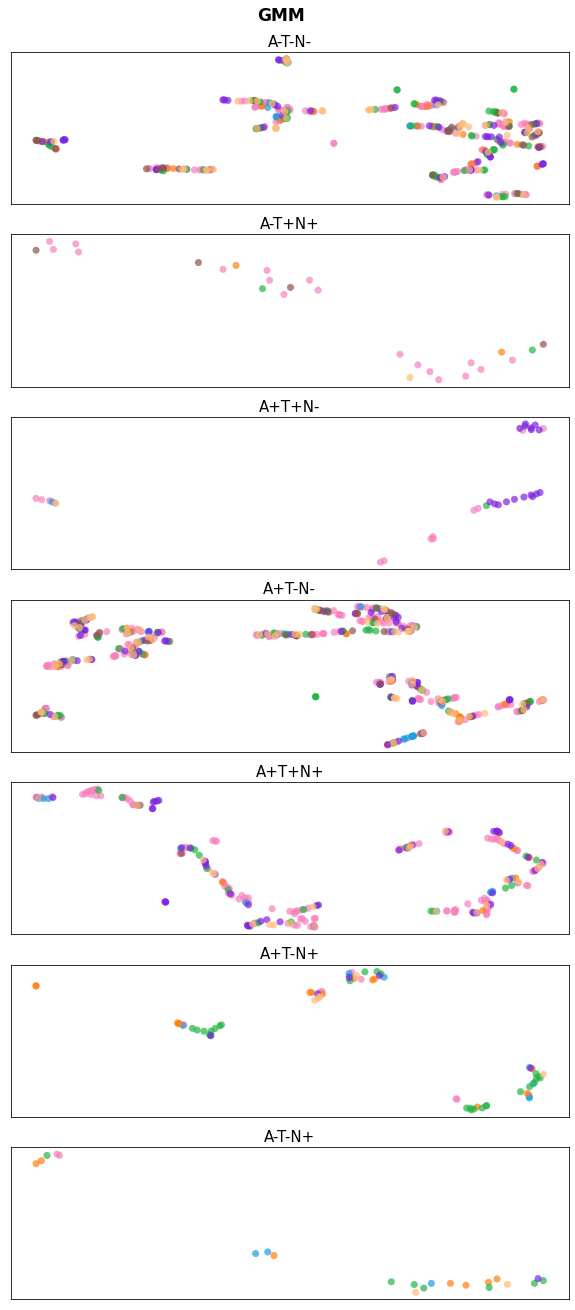

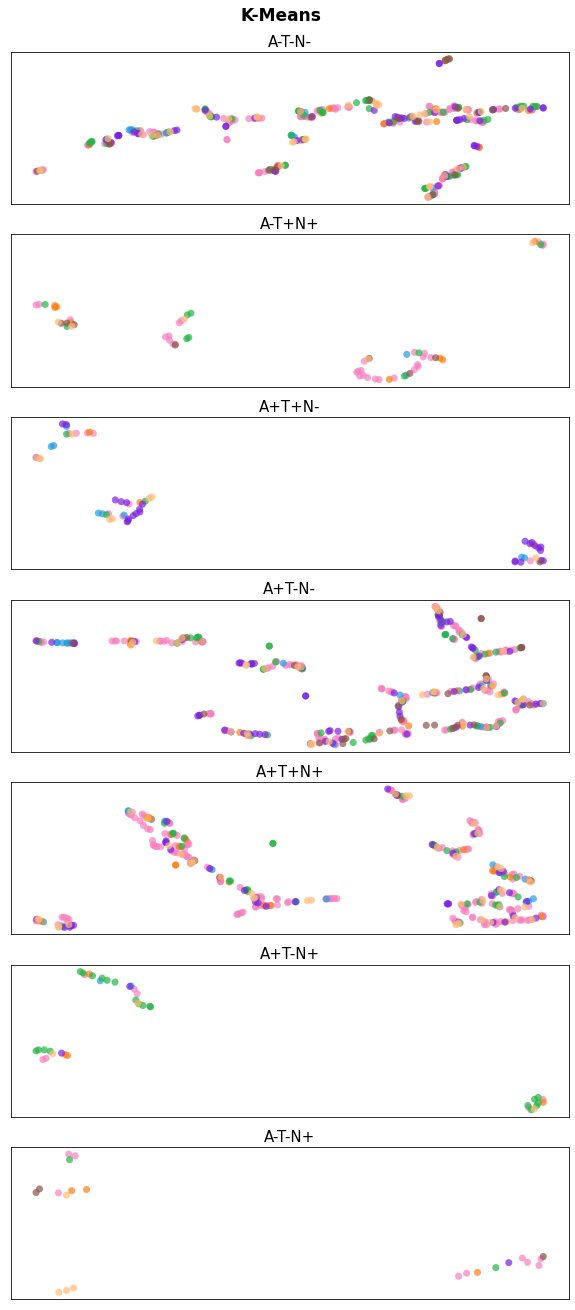

In [72]:
plot_result(seven_cohorts_, ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog'])

In [59]:
UMAP_dfs_corrected_copy = seven_cohorts_.copy()
# order ATN the same way as the paper
atn_order_list = ['A-T-N-', 'A-T+N+', 'A-T-N+', 'A+T+N-', 'A+T-N-', 'A+T-N+', 'A+T+N+']
list_cohort = ['ADNI', 'EDSD', 'ARWIBO', 'NACC', 'JADNI', 'DOD-ADNI', 'PharmaCog']
# make a dictionary of dfs, ond df per threshold method
# rows contain cohort names and columns contain ATN profiles
pat_pet_prof = {i: pd.DataFrame(index=list_cohort, columns=atn_order_list) for i in UMAP_dfs_corrected_copy}

for i in UMAP_dfs_corrected_copy:
    
    for study, num in zip (list_cohort, range(len(list_cohort))):
        UMAP_dfs_corrected_copy[i]['Cohort'].replace({num: study}, inplace=True)
    
    for atn in UMAP_dfs_corrected_copy[i]['ATN'].unique():
        
        for coh__ in UMAP_dfs_corrected_copy[i].loc[UMAP_dfs_corrected_copy[i]['ATN']==atn, 'Cohort'].unique():
            pat_pet_prof[i].loc[coh__, atn] = len(UMAP_dfs_corrected_copy[i].loc[(UMAP_dfs_corrected_copy[i]['ATN']==atn) & (UMAP_dfs_corrected_copy[i]['Cohort']==coh__)])
        
        pat_pet_prof[i].loc['Total', atn] = len(UMAP_dfs_corrected_copy[i][UMAP_dfs_corrected_copy[i]['ATN']==atn])
    
    pat_pet_prof[i].replace({np.nan: 0}, inplace=True)

In [60]:
for i in pat_pet_prof:
    pat_pet_prof[i].to_csv(f"../results/umap/final_plots/patintes_in_umap_{i}.csv")

In [61]:
pat_pet_prof['gmm_cutoffs']

,A-T-N-,A-T+N+,A-T-N+,A+T+N-,A+T-N-,A+T-N+,A+T+N+
ADNI,170,18,2,13,256,8,122
EDSD,14,0,3,1,27,8,10
ARWIBO,23,2,7,0,27,14,7
NACC,80,2,7,1,62,27,17
JADNI,52,0,1,17,63,5,49
DOD-ADNI,28,4,0,0,34,0,4
PharmaCog,46,1,2,1,65,5,23
Total,413,27,22,33,534,67,232


In [62]:
pat_pet_prof['km_cutoffs']

,A-T-N-,A-T+N+,A-T-N+,A+T+N-,A+T-N-,A+T-N+,A+T+N+
ADNI,161,30,9,9,181,7,194
EDSD,12,2,0,8,22,2,16
ARWIBO,18,8,3,3,17,4,22
NACC,71,9,2,3,48,21,34
JADNI,53,0,1,26,65,2,40
DOD-ADNI,23,7,3,1,31,0,5
PharmaCog,40,5,4,9,40,3,42
Total,378,61,22,59,404,39,353


In [49]:
Counter(seven_cohorts_['km_cutoffs']['Cohort'])

Counter({'ADNI': 591,
         'EDSD': 62,
         'ARWIBO': 75,
         'NACC': 188,
         'JADNI': 187,
         'DOD-ADNI': 70,
         'PharmaCog': 143})

In [50]:
pd.DataFrame(seven_cohorts_['gmm_cutoffs'].columns).to_csv(f"../results/umap/final_plots/features.csv")

### Testing

In [51]:

# with PdfPages('../results/umap/final_plots/test_hist.pdf') as pdf:
#     for i in seven_cohorts_:
        
#         coh = seven_cohorts_[i].loc[(seven_cohorts_[i]['Cohort']==0) | (seven_cohorts_[i]['Cohort']==3)]
#         for each_ATN in coh.ATN.unique():

#             for feat in coh.columns[:-5]:
#                 fig, axes = plt.subplots(1, 2, figsize=(15,5))

#                 axes[0].hist(coh.loc[(coh['Cohort']==0) & (coh['ATN']==each_ATN)][feat])
#                 axes[1].hist(coh.loc[(coh['Cohort']==3) & (coh['ATN']==each_ATN)][feat])

#                 axes[0].set_title(f"{feat} in ADNI ({i.split('_')[0].upper()} - {each_ATN})")
#                 axes[1].set_title(f"{feat} in NACC ({i.split('_')[0].upper()} - {each_ATN})")

#                 fig.get_figure()
#                 pdf.savefig(fig)

# # fig.savefig("../results/umap/final_plots/test_hist.pdf", bbox_inches='tight')